In [1]:
import sys
import os
from netCDF4 import chartostring
sys.path.append(os.environ['HOME']+'/work/mpasanalysis')
sys.path.append(os.environ['HOME']+'/work/LESAnalysis')
from mpasanalysis import *
from lesanalysis import *
%matplotlib inline

In [2]:
test = 'Test02'
data_file = os.environ['HOME']+'/scratch/superparameterization/sp_single_column_' \
          +test+'/output/KPP_test.0001-01-01_00.00.00.nc'
mesh_file = data_file
les_file  = os.environ['HOME']+'/scratch/palm/superparameterization/RUN_pgi.aka_openacc_cufft_st_' \
          +test+'_64x64x64/DATA_1D_PR_NETCDF'
# les_file = os.environ['HOME']+'/scratch/superparameterization/sp_single_column_' \
#          +test+'/DATA_1D_PR_NETCDF_0000001'
data_file_kpp = os.environ['HOME']+'/scratch/superparameterization/kpp_single_column_' \
          +test+'/output/KPP_test.0001-01-01_00.00.00.nc'
mesh_file_kpp = data_file_kpp
figdir = os.environ['HOME']+'/work/superParameterization/sp_single_column/'+test
os.makedirs(figdir, exist_ok=True)

In [3]:
data_mpaso = MPASOData(filepath=data_file, filepath_mesh=mesh_file)
data_mpaso_kpp = MPASOData(filepath=data_file_kpp, filepath_mesh=mesh_file_kpp)
data_palm = PALMData1DPR(les_file)

In [18]:
def plot_domain_cell(data_mpaso, varname='temperature', units='deg C', tidx=-1, \
                     savefig=False, figdir=None, **kwargs):
    domain = data_mpaso.get_domain(varname=varname, position='cell', \
                                 name=varname, units=units, tidx=tidx)
    fig = plt.figure(figsize=[12,10])
    domain.plot_xy(linewidth=2, edgecolor='w', **kwargs)
    plt.xlim([-10000, 460000])
    plt.ylim([-10000, 460000])
    plt.axis('off')
    plt.gca().set_aspect(1)
    if savefig:
        plt.tight_layout()
        assert figdir is not None, 'figdir required.'
        figname = figdir+'/'+varname+'_cell.pdf'
        fig.savefig(figname, dpi = 300) 

def plot_field(data_mpaso, varname='temperature', units='degC', idx=0, \
               savefig=False, figdir=None, **kwargs):
    fig = plt.figure(figsize=[6,4])
    img = data_mpaso.get_profile(varname=varname, idx=idx, position='cell', \
                                 name=varname, units=units).plot(**kwargs) 
    fig.autofmt_xdate()
    cb = plt.colorbar(img)
    cb.set_label(varname+' ('+units+')')
    if savefig:
        plt.tight_layout()
        assert figdir is not None, 'figdir required.'
        figname = figdir+'/'+varname+'_field.pdf'
        fig.savefig(figname, dpi = 300) 
    
def plot_field_pfl(data_mpaso, varname='temperature', units='deg C', idx=0, xlim=None, ylim=None, \
                   savefig=False, figdir=None, **kwargs):
    fig = plt.figure(figsize=[6,4])
    pfl = data_mpaso.get_profile(varname=varname, idx=idx, position='cell', \
                                 name=varname, units=units)
    d = pfl.data[-1,:]
    z = pfl.z
    plt.plot(d, z, **kwargs)
    plt.xlabel(varname+' ('+units+')')
    plt.ylabel('z (m)')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if savefig:
        plt.tight_layout()
        assert figdir is not None, 'figdir required.'
        figname = figdir+'/'+varname+'_field_pfl.pdf'
        fig.savefig(figname, dpi = 300) 
    
def plot_fields(data_mpaso, data_palm, varname_mpaso='temperature', varname_palm='pt', \
               varname='temperature', units='degC', \
               savefig=False, figdir=None, **kwargs):
    fig, axarr = plt.subplots(2,2, sharex=True, sharey=True)
    fig.set_size_inches(9, 6)
    fig1 = data_palm.read_profile(varname=varname_palm).plot(axis=axarr[0,0], title='PALM', \
                                                             ylabel='z (m)', **kwargs)
    fig2 = data_mpaso.get_profile(varname=varname_mpaso+'LES', idx=0, position='cellLES', \
                                 name=varname, units=units).plot(axis=axarr[0,1], title='PALM in MPASO', \
                                                                 ylabel='off', **kwargs) 
#     fig3 = data_mpaso.get_profile(varname=varname_mpaso, idx=10, position='cell', \
#                                  name=varname, units=units).plot(axis=axarr[1,0], \
#                                                                   title='MPASO w/ KPP', **kwargs) 
    fig3 = data_mpaso_kpp.get_profile(varname=varname_mpaso, idx=0, position='cell', \
                                 name=varname, units=units).plot(axis=axarr[1,0], \
                                                                 title='MPASO w/ KPP', **kwargs) 
    fig4 = data_mpaso.get_profile(varname=varname_mpaso, idx=0, position='cell', \
                                 name=varname, units=units).plot(axis=axarr[1,1], title='MPASO w/ PALM', \
                                                                 ylabel='off', **kwargs) 
    fig.autofmt_xdate()
    # reduce margin
    plt.tight_layout()

    # colorbar
    plt.subplots_adjust(right=0.86)
    cax = plt.axes([0.8, 0.25, 0.1, 0.5])
    cax.set_visible(False)
    cb = plt.colorbar(fig1, ax=cax)
    cb.update_ticks()
    cb.set_label(varname+' ('+units+')')
    if savefig:
        assert figdir is not None, 'figdir required.'
        figname = figdir+'/'+varname+'_fields.pdf'
        fig.savefig(figname, dpi = 300) 
    
def plot_fields_pfl(data_mpaso, data_palm, varname_mpaso='temperature', varname_palm='pt', \
                    varname='temperature', units='deg C', xlim=None, ylim=None, \
                    savefig=False, figdir=None):
    fig = plt.figure(figsize=[4.5,3])
    pfl1 = data_palm.read_profile(varname=varname_palm)
    d1 = pfl1.data[-1,:]
    z1 = pfl1.z
    pfl2 = data_mpaso.get_profile(varname=varname_mpaso+'LES', idx=0, position='cellLES', \
                                  name=varname, units=units)
    d2 = pfl2.data[-1,:]
    z2 = pfl2.z
#     pfl3 = data_mpaso.get_profile(varname=varname_mpaso, idx=10, position='cell', \
#                                  name=varname, units=units)
    pfl3 = data_mpaso_kpp.get_profile(varname=varname_mpaso, idx=0, position='cell', \
                                 name=varname, units=units)
    d3 = pfl3.data[-1,:]
    z3 = pfl3.z
    pfl4 = data_mpaso.get_profile(varname=varname_mpaso, idx=0, position='cell', \
                                 name=varname, units=units)
    d4 = pfl4.data[-1,:]
    z4 = pfl4.z
    plt.plot(d1, z1, '-k', label='PALM')
    plt.plot(d2, z2, '-b', label='PALM in MPASO')
    plt.plot(d3, z3, '-r', label='MPASO w/ KPP')
    plt.plot(d4, z4, '-g', label='MPASO w/ PAML')
    plt.legend()
    plt.xlabel(varname+' ('+units+')')
    plt.ylabel('z (m)')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if savefig:
        plt.tight_layout()
        assert figdir is not None, 'figdir required.'
        figname = figdir+'/'+varname+'_fields_pfl.pdf'
        fig.savefig(figname, dpi = 300) 

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_single_column_Test02/output/KPP_test.0001-01-01_00.00.00.nc


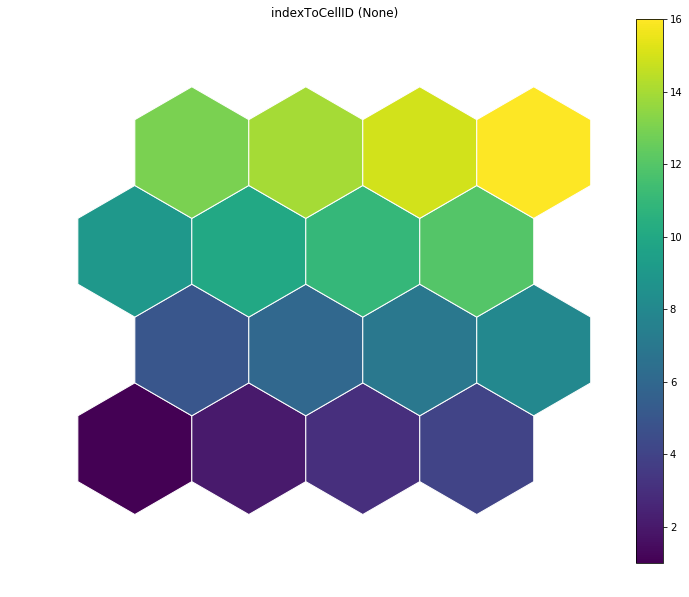

In [5]:
plot_domain_cell(data_mpaso, varname='indexToCellID', units='None', tidx=-1)

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_single_column_Test02/output/KPP_test.0001-01-01_00.00.00.nc


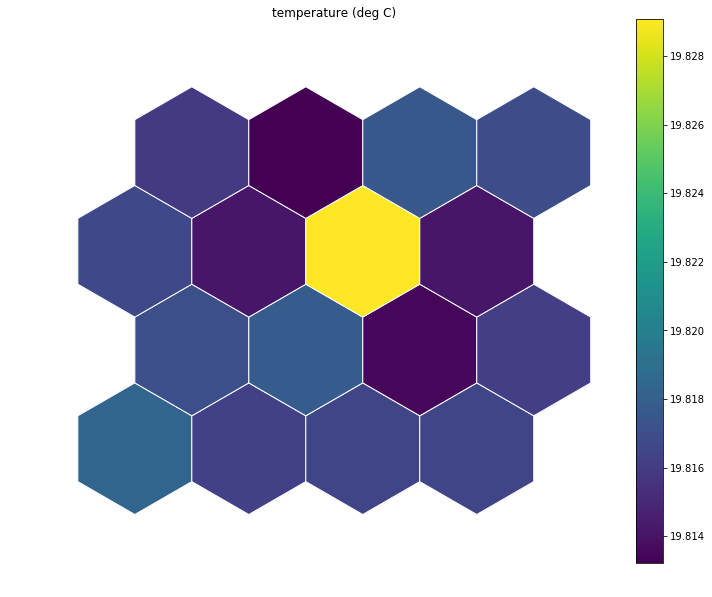

In [6]:
plot_domain_cell(data_mpaso, varname='temperature', units='deg C', tidx=-1)

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_single_column_Test02/output/KPP_test.0001-01-01_00.00.00.nc


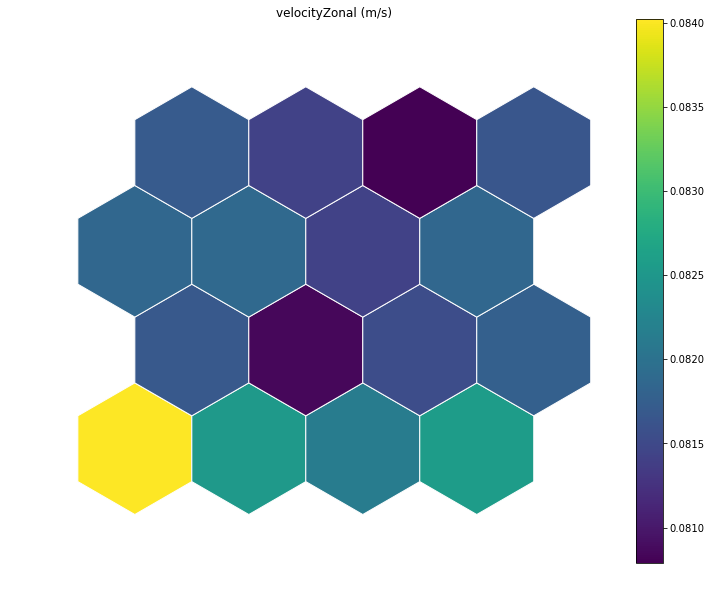

In [7]:
plot_domain_cell(data_mpaso, varname='velocityZonal', units='m/s', tidx=-1)

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_single_column_Test02/output/KPP_test.0001-01-01_00.00.00.nc


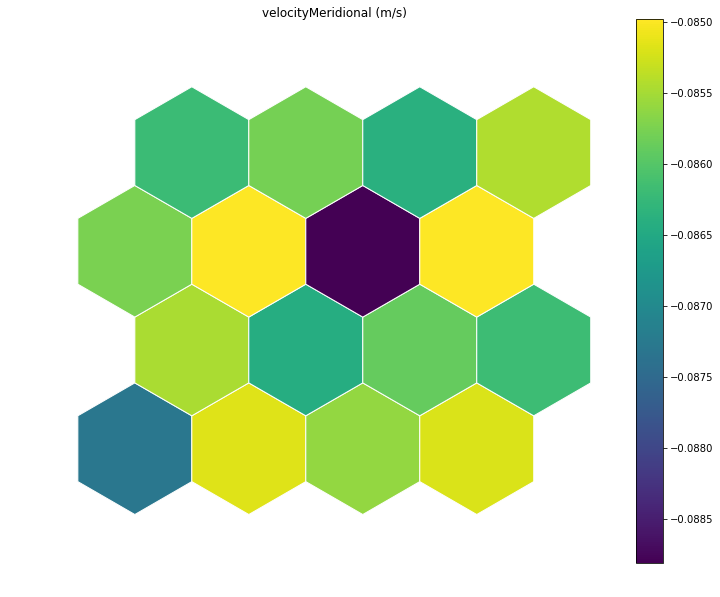

In [8]:
plot_domain_cell(data_mpaso, varname='velocityMeridional', units='m/s', tidx=-1)

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_single_column_Test02/output/KPP_test.0001-01-01_00.00.00.nc


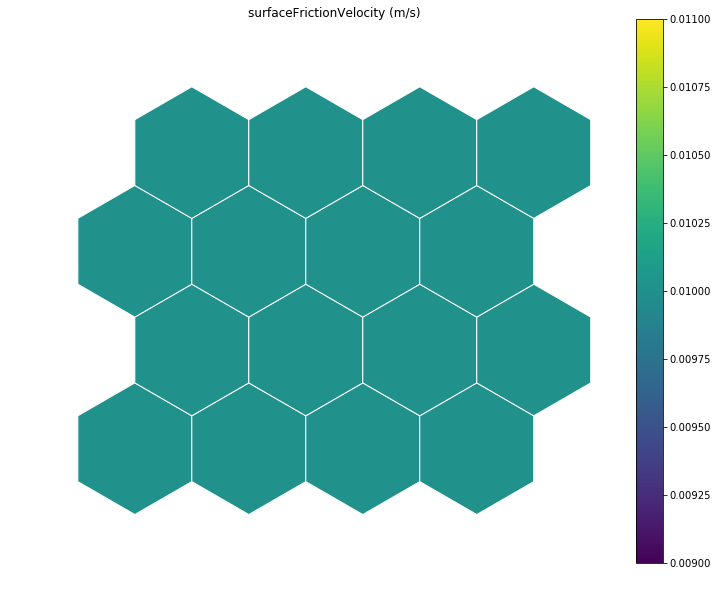

In [9]:
plot_domain_cell(data_mpaso, varname='surfaceFrictionVelocity', units='m/s', tidx=-1)

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_single_column_Test02/output/KPP_test.0001-01-01_00.00.00.nc


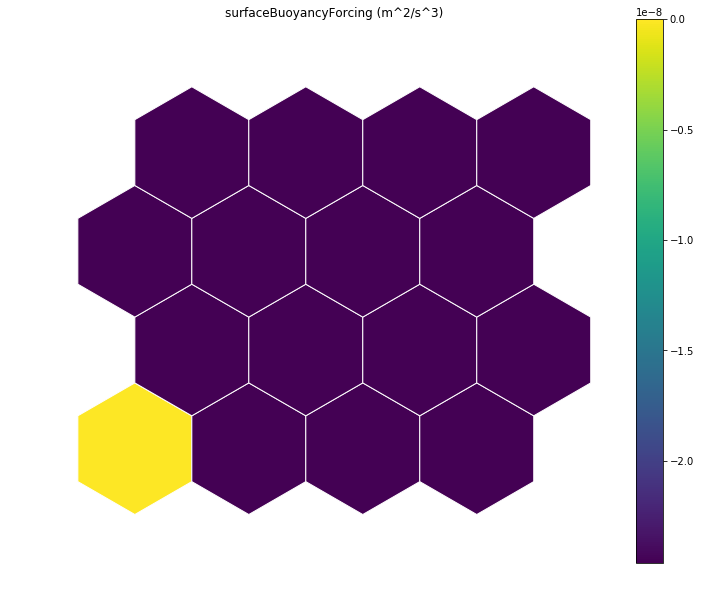

In [10]:
plot_domain_cell(data_mpaso, varname='surfaceBuoyancyForcing', units='m^2/s^3', tidx=-1)

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_single_column_Test02/output/KPP_test.0001-01-01_00.00.00.nc


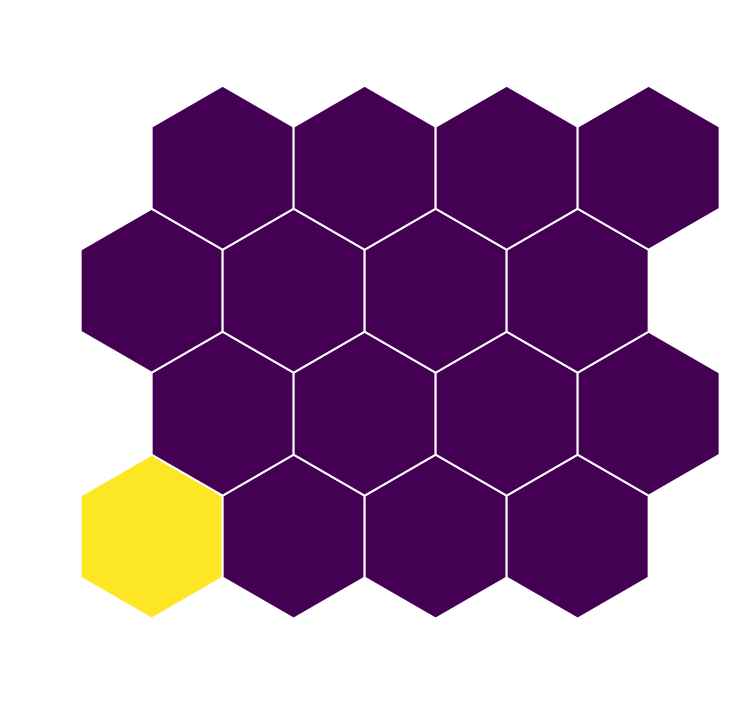

In [19]:
plot_domain_cell(data_mpaso, varname='lesCell', units=None, tidx=-1, add_title=False, add_colorbar=False, \
                 savefig=True, figdir=figdir)

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_single_column_Test02/output/KPP_test.0001-01-01_00.00.00.nc


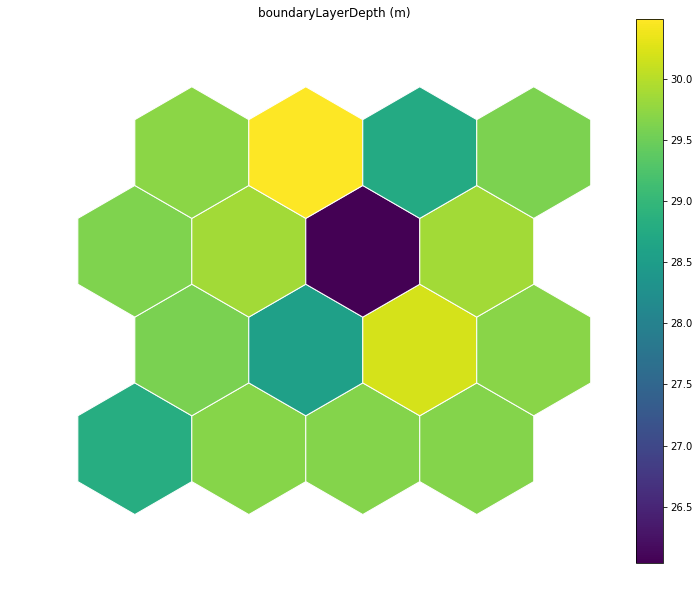

In [12]:
plot_domain_cell(data_mpaso, varname='boundaryLayerDepth', units='m', tidx=-1)

In [13]:
tstart = datetime(1,1,1,0,30,0)
tend = datetime(1,1,2,0,0,0)
xlim = [tstart, tend]
ylim = [-40, 0]

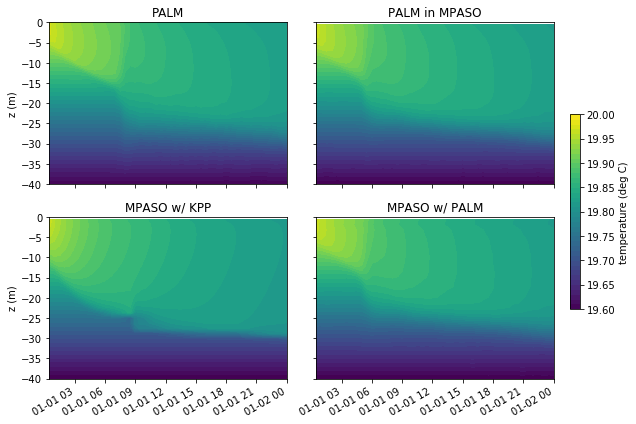

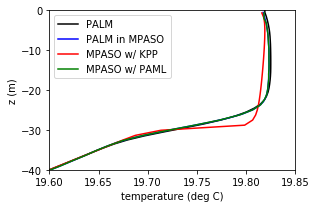

In [14]:
# levels=np.linspace(15.5,16.2,71)
levels=np.linspace(19.6,20,41)
plot_fields(data_mpaso=data_mpaso, data_palm=data_palm, varname_mpaso='temperature', varname_palm='pt', \
            varname='temperature', units='deg C', levels=levels, xlim=xlim, ylim=ylim, \
            savefig=True, figdir=figdir)
# plot_fields_pfl(data_mpaso=data_mpaso, data_palm=data_palm, varname_mpaso='temperature', varname_palm='pt', \
#                varname='temperature', units='deg C', xlim=[np.min(levels),np.max(levels)], ylim=ylim)
plot_fields_pfl(data_mpaso=data_mpaso, data_palm=data_palm, varname_mpaso='temperature', varname_palm='pt', \
               varname='temperature', units='deg C', xlim=[19.6, 19.85], ylim=ylim, savefig=True, figdir=figdir)

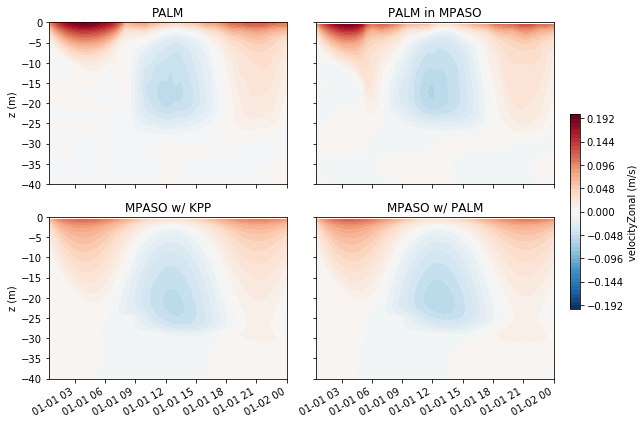

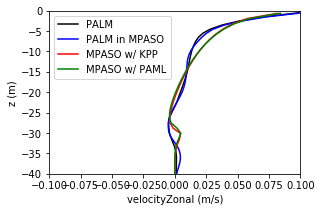

In [15]:
levels = np.linspace(-0.2, 0.2, 51)
cmap = 'RdBu_r'
plot_fields(data_mpaso=data_mpaso, data_palm=data_palm, varname_mpaso='velocityZonal', varname_palm='u', \
               varname='velocityZonal', units='m/s', levels=levels, xlim=xlim, ylim=ylim, cmap=cmap)
plot_fields_pfl(data_mpaso=data_mpaso, data_palm=data_palm, varname_mpaso='velocityZonal', \
                varname_palm='u', varname='velocityZonal', units='m/s', xlim=[-0.1,0.1], ylim=ylim)

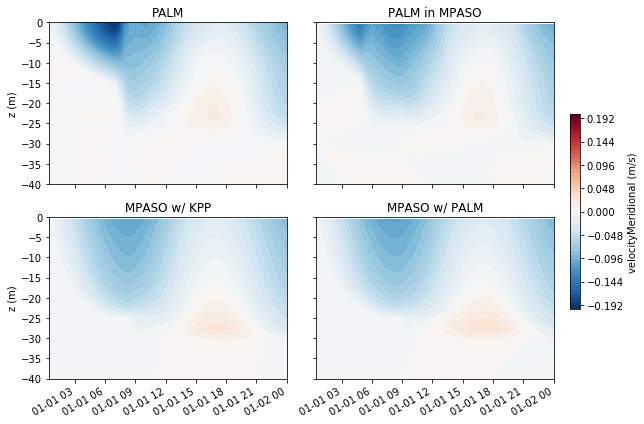

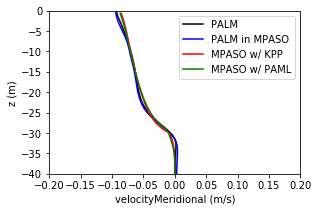

In [16]:
levels = np.linspace(-0.2, 0.2, 51)
cmap = 'RdBu_r'
plot_fields(data_mpaso=data_mpaso, data_palm=data_palm, varname_mpaso='velocityMeridional', varname_palm='v', \
               varname='velocityMeridional', units='m/s', levels=levels, xlim=xlim, ylim=ylim, cmap=cmap)
plot_fields_pfl(data_mpaso=data_mpaso, data_palm=data_palm, varname_mpaso='velocityMeridional', \
                varname_palm='v', varname='velocityMeridional', units='m/s', xlim=[-0.2,0.2], ylim=ylim)

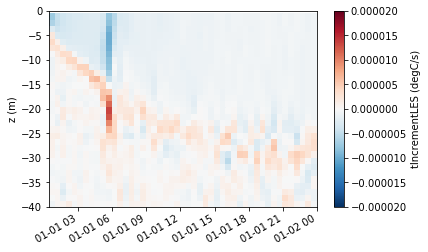

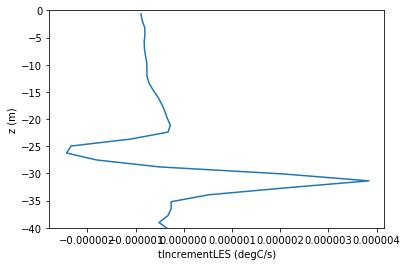

In [17]:
# levels = np.linspace(-0.2, 0.2, 51)
levels = None
cmap = 'RdBu_r'
varname = 'tIncrementLES'
units = 'degC/s'
plot_field(data_mpaso=data_mpaso, varname=varname, units=units, \
           xlim=xlim, ylim=ylim, cmap=cmap, ptype='pcolor', vmax=2e-5, vmin=-2e-5)
plot_field_pfl(data_mpaso=data_mpaso, varname=varname, units=units, ylim=ylim)